In [1]:
using DataFrames
using Flux
import JSON
using LinearAlgebra
using MLUtils
using Plots
using StatsBase
using StatsPlots
using Statistics

include("../helpers.jl");
include("../stats.jl");

## Edit before running on new data

In [2]:
x_columns_to_drop = []
y_columns_to_drop = []
target_directory = "../data/full_opt_15KeV/"

"../data/full_opt_15KeV/"

## Getting data together

In [3]:
# get data
x_df = DataFrame(
    DVAR1=Float32[],
    DVAR2=Float32[],
    DVAR3=Float32[],
    DVAR4=Float32[],
    DVAR5=Float32[],
    DVAR6=Float32[],
    DVAR7=Float32[],
    DVAR8=Float32[],
    DVAR9=Float32[],
    DVAR10=Float32[],
    DVAR11=Float32[],
    DVAR12=Float32[],
    DVAR13=Float32[],
    DVAR14=Float32[]
)
y_df = DataFrame(
    OBJ1=Float32[],
    OBJ2=Float32[],
    OBJ3=Float32[],
    OBJ4=Float32[],
    OBJ5=Float32[],
    OBJ6=Float32[]
)

x_df, y_df = readjsonsfromdirectory(target_directory, x_df, y_df);

## Data preprocessing

In [4]:
# decorrelate x_df
function dynamicscale(data_raw, dynamic_lower, upper)
    return (data_raw .- dynamic_lower) ./ (upper .- dynamic_lower)
end

max_dvar_3 = 160
eta_3 = 10.
max_dvar_5 = 1.85
eta_5 = 0.05
max_dvar_12 = 2.0
eta_12 = 0.05
max_dvar_9 = -25.
eta_9 = 2.5
max_dvar_13 = -20.
eta_13 = 2.5

dvar_3_prime = dynamicscale(x_df[:, "DVAR3"], eta_3 .+ x_df[:, "DVAR2"], max_dvar_3)
dvar_5_prime = dynamicscale(x_df[:, "DVAR5"], x_df[:, "DVAR4"] .+ eta_5, max_dvar_5)
dvar_12_prime = dynamicscale(x_df[:, "DVAR12"], x_df[:, "DVAR5"] .+ eta_12, max_dvar_12)
dvar_9_prime = dynamicscale(x_df[:, "DVAR9"], x_df[:, "DVAR8"] .+ eta_9, max_dvar_9)
dvar_13_prime = dynamicscale(x_df[:, "DVAR13"], x_df[:, "DVAR9"] .+ eta_13, max_dvar_13)

x_df[:, "DVAR3"] = dvar_3_prime;
x_df[:, "DVAR5"] = dvar_5_prime;
x_df[:, "DVAR12"] = dvar_12_prime;
x_df[:, "DVAR9"] = dvar_9_prime;
x_df[:, "DVAR13"] = dvar_13_prime;

In [5]:
# scaling data
x_scaled_df = minmaxscaledf(x_df)[1]
y_scaled_df = minmaxscaledf(y_df)[1]

@assert(all(maximum(y_scaled_df[!, colname]) == 1. for colname in names(y_scaled_df)))
@assert(all(minimum(y_scaled_df[!, colname]) == -1. for colname in names(y_scaled_df)))

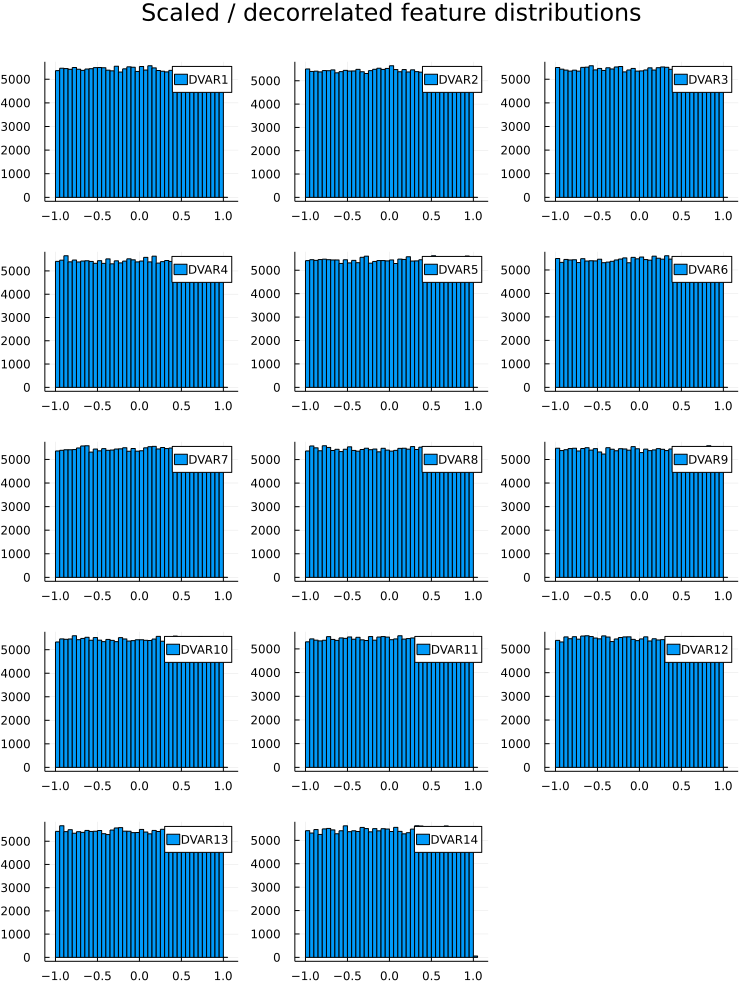

In [6]:
# plot features
l = @layout [grid(5, 3)]

subplots = []
for i in 1:14
    hist = histogram(x_scaled_df[:, "DVAR$i"], label="DVAR$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 1000), plot_title="Scaled / decorrelated feature distributions")

In [7]:
# split into training and test sets
train_frac = 0.8
data_size = nrow(x_scaled_df)
train_size = trunc(Int, train_frac * data_size)

train_indexes = sample(1:data_size, train_size, replace=false)
test_indexes = (1:data_size)[(1:data_size) .∉ Ref(train_indexes)]

@assert(length(train_indexes) + length(test_indexes) == data_size)

x_train_df = x_scaled_df[train_indexes, :]; x_test_df = x_scaled_df[test_indexes, :];
y_train_df = y_scaled_df[train_indexes, :]; y_test_df = y_scaled_df[test_indexes, :];

In [8]:
# format to arrays
x_train = Float64.(Matrix(x_train_df)); x_test = Float64.(Matrix(x_test_df));
y_train = Float64.(Matrix(y_train_df)); y_test = Float64.(Matrix(y_test_df));

In [9]:
# get dimensions
x_dimension = size(x_train)[2];
y_dimension = size(y_train)[2];

In [10]:
function resneuralnetworkwithbatchnorm()
    Chain(
        Dense(x_dimension, 50),
        BatchNorm(50, x->σ.(x)),
        SkipConnection(
            Chain(
                Dense(50, 50),
                BatchNorm(50, x->σ.(x)),
                Dense(50, 50),
                BatchNorm(50, x->σ.(x)),
                Dense(50, 50),
                BatchNorm(50, x->σ.(x)),
            ),
            (a, b) -> cat(a, b, dims=1) # resnet architecture. we now have a 100-width input
        ),
        Dense(100, 50),
        BatchNorm(50, x->σ.(x)),
        SkipConnection(
            Chain(
                Dense(50, 50),
                BatchNorm(50, x->σ.(x)),
                Dense(50, 50),
                BatchNorm(50, x->σ.(x)),
                Dense(50, 50),
                BatchNorm(50, x->σ.(x)),
            ),
            (a, b) -> cat(a, b, dims=1)
        ),
        Dense(100, 50),
        BatchNorm(50, x->σ.(x)),
        Dense(50, y_dimension)
    )
end

resneuralnetworkwithbatchnorm (generic function with 1 method)

In [11]:
# organizing data into batches
batch_size = 1024
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [12]:
# defining our model, optimization algorithm and loss function
m = resneuralnetworkwithbatchnorm()
learning_rate = 0.001
optimizer = ADAM(learning_rate)
loss(x, y) = Flux.mse(m(x), y)

# training
n_epochs = 2500
training_losses = Float32[]
epochs = Int32[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss, Flux.params(m), data_loader, optimizer)
    push!(epochs, epoch)
    l = 0.
    for d in data_loader
        l += loss(d...)
    end
    println(" loss=$l")
    push!(training_losses, l)
    
    # learning rate decay, just for fun
    #= 
    if (epoch % 50 == 0) & (epoch < 151)
        learning_rate = learning_rate * 0.1
        optimizer = ADAM(learning_rate)
    end =#
end

epoch 1, loss=4.596866579620027
epoch 2, loss=2.2052557738219503
epoch 3, loss=1.909968274332219
epoch 4, loss=1.588670373281873
epoch 5, loss=1.479036802066183
epoch 6, loss=1.3478236851495973
epoch 7, loss=1.3260361306275952
epoch 8, loss=1.2622321500962896
epoch 9, loss=1.2280518771643396
epoch 10, loss=1.1872941318200418
epoch 11, loss=1.3060458001837676
epoch 12, loss=1.1801249809248915
epoch 13, loss=1.1407366912378536
epoch 14, loss=1.124020243839503
epoch 15, loss=1.2616249157650403
epoch 16, loss=1.139676727475812
epoch 17, loss=1.0951729182717114
epoch 18, loss=1.1052375821063591
epoch 19, loss=1.1055342162528647
epoch 20, loss=1.1059909645173605
epoch 21, loss=1.171217668432541
epoch 22, loss=1.0787180669619119
epoch 23, loss=1.06828595044778
epoch 24, loss=1.0590266790100025
epoch 25, loss=1.1255766779903695
epoch 26, loss=1.0609701314325737
epoch 27, loss=1.0928121843310608
epoch 28, loss=1.0654690894428904
epoch 29, loss=1.0417326774742524
epoch 30, loss=1.022972257776859

epoch 239, loss=0.8504795457654464
epoch 240, loss=0.8542156280159554
epoch 241, loss=0.8532663470921925
epoch 242, loss=0.8854129601347818
epoch 243, loss=0.850869051831034
epoch 244, loss=0.8681215880810347
epoch 245, loss=0.872440977446269
epoch 246, loss=0.8513010113598467
epoch 247, loss=0.8353835810169821
epoch 248, loss=0.8392783008545633
epoch 249, loss=0.8559046191273527
epoch 250, loss=0.8675410782331838
epoch 251, loss=0.8708424151063683
epoch 252, loss=0.8546307530748476
epoch 253, loss=0.8477293457099365
epoch 254, loss=0.851120407612953
epoch 255, loss=0.8540140191119671
epoch 256, loss=0.8464735122099925
epoch 257, loss=0.9151361083380032
epoch 258, loss=0.846677811711667
epoch 259, loss=0.8487405514048555
epoch 260, loss=0.8661918757751773
epoch 261, loss=0.8368806326042796
epoch 262, loss=0.8562361410038369
epoch 263, loss=0.8620548124624291
epoch 264, loss=0.8559005792228738
epoch 265, loss=0.834320857737118
epoch 266, loss=0.8965225361454147
epoch 267, loss=0.8397288

epoch 473, loss=0.8320933133957302
epoch 474, loss=0.8216848104581409
epoch 475, loss=0.7976429675918578
epoch 476, loss=0.8250070958236846
epoch 477, loss=0.807696693194191
epoch 478, loss=0.8170383578412841
epoch 479, loss=0.8139622402555124
epoch 480, loss=0.8109412314341605
epoch 481, loss=0.8285477644855105
epoch 482, loss=0.8103189281816193
epoch 483, loss=0.8115760763861349
epoch 484, loss=0.8062265478737559
epoch 485, loss=0.8005939960447688
epoch 486, loss=0.8060638000735173
epoch 487, loss=0.8119820928971134
epoch 488, loss=0.8036421938470246
epoch 489, loss=0.8002051397876644
epoch 490, loss=0.8547923038568297
epoch 491, loss=0.8177050534984842
epoch 492, loss=0.8087263062409342
epoch 493, loss=0.8037651705672473
epoch 494, loss=0.8057858905114283
epoch 495, loss=0.8341456008510894
epoch 496, loss=0.8127508693083497
epoch 497, loss=0.805189982664077
epoch 498, loss=0.8057408596889367
epoch 499, loss=0.8268364037315223
epoch 500, loss=0.8114245827628295
epoch 501, loss=0.8011

epoch 707, loss=0.7916334173301646
epoch 708, loss=0.8302604238898021
epoch 709, loss=0.7891967746680634
epoch 710, loss=0.7855837922633532
epoch 711, loss=0.7971639490459614
epoch 712, loss=0.7976183998199858
epoch 713, loss=0.7940185175770459
epoch 714, loss=0.827849879497699
epoch 715, loss=0.7952836991921103
epoch 716, loss=0.7943389868481638
epoch 717, loss=0.806641736152096
epoch 718, loss=0.7940030919118084
epoch 719, loss=0.7948502815212168
epoch 720, loss=0.823045471493412
epoch 721, loss=0.7900996949841497
epoch 722, loss=0.795198531201185
epoch 723, loss=0.785244519337697
epoch 724, loss=0.7856089613672038
epoch 725, loss=0.7870508054584648
epoch 726, loss=0.7996748014405819
epoch 727, loss=0.7997680427815987
epoch 728, loss=0.8094803057684397
epoch 729, loss=0.797362564347295
epoch 730, loss=0.8055761117600642
epoch 731, loss=0.8239035629485901
epoch 732, loss=0.786358386472003
epoch 733, loss=0.7933750811443465
epoch 734, loss=0.7863768757390452
epoch 735, loss=0.794211735

epoch 942, loss=0.7755193187926731
epoch 943, loss=0.7828584989708347
epoch 944, loss=0.7729457628613586
epoch 945, loss=0.7902096830674545
epoch 946, loss=0.7619620672553171
epoch 947, loss=0.7695170552320175
epoch 948, loss=0.7813863635118902
epoch 949, loss=0.802948114682529
epoch 950, loss=0.7711086251470178
epoch 951, loss=0.777639864469307
epoch 952, loss=0.7679442110684546
epoch 953, loss=0.7821974243444746
epoch 954, loss=0.7741153714145886
epoch 955, loss=0.7912605245078
epoch 956, loss=0.7652940331567687
epoch 957, loss=0.8014881241857306
epoch 958, loss=0.807596990716718
epoch 959, loss=0.7732626064000058
epoch 960, loss=0.7692064296710949
epoch 961, loss=0.7681676904436031
epoch 962, loss=0.7649655790033317
epoch 963, loss=0.7963648712240282
epoch 964, loss=0.776941823444151
epoch 965, loss=0.7840239670208483
epoch 966, loss=0.7718359036795224
epoch 967, loss=0.777685095507061
epoch 968, loss=0.7666075094275274
epoch 969, loss=0.768745933839213
epoch 970, loss=0.77602609137

epoch 1172, loss=0.7544311980090375
epoch 1173, loss=0.7630728626318728
epoch 1174, loss=0.7654173468388239
epoch 1175, loss=0.7562653273420964
epoch 1176, loss=0.7606740664331192
epoch 1177, loss=0.7505706782841878
epoch 1178, loss=0.755958368751569
epoch 1179, loss=0.7612221211274217
epoch 1180, loss=0.7567442294777206
epoch 1181, loss=0.7505653179033384
epoch 1182, loss=0.7579636800401556
epoch 1183, loss=0.7574897745896603
epoch 1184, loss=0.7468988996897878
epoch 1185, loss=0.7534913478069769
epoch 1186, loss=0.7628484309647976
epoch 1187, loss=0.7651729679967815
epoch 1188, loss=0.7473084865048074
epoch 1189, loss=0.767350194290712
epoch 1190, loss=0.7537048470424984
epoch 1191, loss=0.7744081084208115
epoch 1192, loss=0.7511655712678409
epoch 1193, loss=0.7707666397896665
epoch 1194, loss=0.7595664590894584
epoch 1195, loss=0.7625871478839318
epoch 1196, loss=0.7506172829319306
epoch 1197, loss=0.764275352824534
epoch 1198, loss=0.7546392437801727
epoch 1199, loss=0.751915543423

epoch 1401, loss=0.7422346824143965
epoch 1402, loss=0.7508766314297501
epoch 1403, loss=0.7414119649430365
epoch 1404, loss=0.7353510464468808
epoch 1405, loss=0.7360453316451232
epoch 1406, loss=0.7421125193278449
epoch 1407, loss=0.7357955816624249
epoch 1408, loss=0.7368977736698129
epoch 1409, loss=0.748569735575431
epoch 1410, loss=0.7413475352662758
epoch 1411, loss=0.7551815648320058
epoch 1412, loss=0.7339175644934623
epoch 1413, loss=0.7349913730957771
epoch 1414, loss=0.744744615898497
epoch 1415, loss=0.7341622983581758
epoch 1416, loss=0.7399854285454802
epoch 1417, loss=0.7304500900982136
epoch 1418, loss=0.7406413488359356
epoch 1419, loss=0.7342114710950107
epoch 1420, loss=0.7416047498041128
epoch 1421, loss=0.7549148891900385
epoch 1422, loss=0.7353369774988674
epoch 1423, loss=0.7264490004256574
epoch 1424, loss=0.7432175641217303
epoch 1425, loss=0.7366723884130375
epoch 1426, loss=0.7353228508990594
epoch 1427, loss=0.7539615045145148
epoch 1428, loss=0.73507113016

epoch 1629, loss=0.742943327107638
epoch 1630, loss=0.7281845914151693
epoch 1631, loss=0.7229058128725034
epoch 1632, loss=0.7255633162153038
epoch 1633, loss=0.7241367128055802
epoch 1634, loss=0.7157569460210171
epoch 1635, loss=0.7409650080534501
epoch 1636, loss=0.7211456527103169
epoch 1637, loss=0.7235384579998515
epoch 1638, loss=0.7135281151056037
epoch 1639, loss=0.7244852185403925
epoch 1640, loss=0.7270656717107697
epoch 1641, loss=0.7268392022990795
epoch 1642, loss=0.7232940729234332
epoch 1643, loss=0.7173392852461002
epoch 1644, loss=0.7193930752789178
epoch 1645, loss=0.7169066697247646
epoch 1646, loss=0.7236701290236298
epoch 1647, loss=0.7265283842761375
epoch 1648, loss=0.7322170972132631
epoch 1649, loss=0.7431307123844887
epoch 1650, loss=0.7157074716250343
epoch 1651, loss=0.725713987534849
epoch 1652, loss=0.7231598477473449
epoch 1653, loss=0.7202956438073552
epoch 1654, loss=0.7211034366470798
epoch 1655, loss=0.733635392576294
epoch 1656, loss=0.732554265973

epoch 1857, loss=0.7033216670802084
epoch 1858, loss=0.7177094361413229
epoch 1859, loss=0.7153155056829934
epoch 1860, loss=0.7119077030423334
epoch 1861, loss=0.7069971040052601
epoch 1862, loss=0.7042871529838335
epoch 1863, loss=0.709929252230547
epoch 1864, loss=0.732267701976425
epoch 1865, loss=0.714805970028135
epoch 1866, loss=0.7056630878964453
epoch 1867, loss=0.7107989261957857
epoch 1868, loss=0.7078540198374204
epoch 1869, loss=0.7079275621852369
epoch 1870, loss=0.7019474426862334
epoch 1871, loss=0.7170372664212279
epoch 1872, loss=0.7022158403787169
epoch 1873, loss=0.7137663931272874
epoch 1874, loss=0.7078600188525496
epoch 1875, loss=0.7085658291400437
epoch 1876, loss=0.7069754450616672
epoch 1877, loss=0.7076164530732866
epoch 1878, loss=0.7008903112645141
epoch 1879, loss=0.7162472136682709
epoch 1880, loss=0.7013877957075157
epoch 1881, loss=0.7073724876897483
epoch 1882, loss=0.7090539569506146
epoch 1883, loss=0.7253823978458468
epoch 1884, loss=0.709398086840

epoch 2085, loss=0.7151695858069514
epoch 2086, loss=0.69496440795801
epoch 2087, loss=0.6970982553256969
epoch 2088, loss=0.7009663205081832
epoch 2089, loss=0.7013210515426678
epoch 2090, loss=0.7005449829982893
epoch 2091, loss=0.6899437897084645
epoch 2092, loss=0.7007941184755536
epoch 2093, loss=0.7105182772657697
epoch 2094, loss=0.6979636625070003
epoch 2095, loss=0.6986868583166618
epoch 2096, loss=0.6962840169368486
epoch 2097, loss=0.7052189728741401
epoch 2098, loss=0.6989116279756892
epoch 2099, loss=0.697256194857602
epoch 2100, loss=0.7023167179635721
epoch 2101, loss=0.7174269636009812
epoch 2102, loss=0.7009624392140288
epoch 2103, loss=0.6971867468241915
epoch 2104, loss=0.7074343250558602
epoch 2105, loss=0.693136537818541
epoch 2106, loss=0.6897238472992524
epoch 2107, loss=0.6975304518927342
epoch 2108, loss=0.6944185279087578
epoch 2109, loss=0.694248817187863
epoch 2110, loss=0.7027955542225469
epoch 2111, loss=0.6984287845826805
epoch 2112, loss=0.70283483617038

epoch 2313, loss=0.685255057280066
epoch 2314, loss=0.6906610060730112
epoch 2315, loss=0.6815803650260491
epoch 2316, loss=0.6876892150586756
epoch 2317, loss=0.6954844050391865
epoch 2318, loss=0.6859785398104378
epoch 2319, loss=0.6941671228862863
epoch 2320, loss=0.6805329823885067
epoch 2321, loss=0.6855601509113747
epoch 2322, loss=0.6889607705805267
epoch 2323, loss=0.684292270817107
epoch 2324, loss=0.6917765237306948
epoch 2325, loss=0.6893752061429783
epoch 2326, loss=0.6899074545256472
epoch 2327, loss=0.6979822089609931
epoch 2328, loss=0.6899061696263565
epoch 2329, loss=0.6892471645601627
epoch 2330, loss=0.683036655219922
epoch 2331, loss=0.6863354155408734
epoch 2332, loss=0.6872511407839461
epoch 2333, loss=0.6916811969154154
epoch 2334, loss=0.6884529374392749
epoch 2335, loss=0.6905209721834039
epoch 2336, loss=0.6825426420416041
epoch 2337, loss=0.6869464021591373
epoch 2338, loss=0.6881254403520334
epoch 2339, loss=0.6782249935840877
epoch 2340, loss=0.685905389902

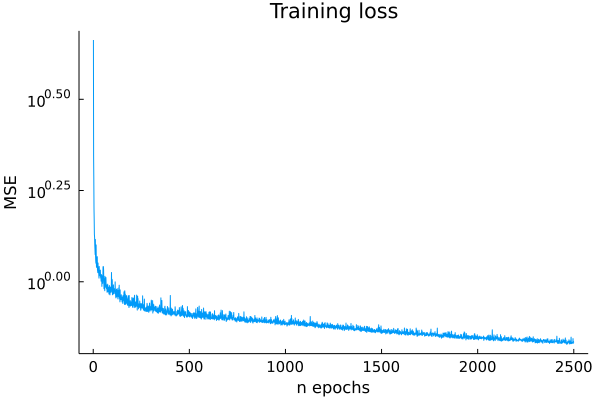

In [13]:
# plot training history
plot(epochs, training_losses;
    title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false,
    label="", dpi=400,
    grid=false, xtickfontsize=10, ytickfontsize=10, legendfontsize=10, yaxis=:log)

## Model evaluation

In [14]:
y_train_preds = m(x_train')';
y_test_preds = m(x_test')';

In [15]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

r2score_multidim (generic function with 2 methods)

In [16]:
r2_train = r2score_multidim(y_train, y_train_preds)
r2_test = r2score_multidim(y_test, y_test_preds)
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

r2 on training set: 0.9343231991305999
r2 on test set: 0.9192579701601087


In [17]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

adjustedr2score_multidim (generic function with 2 methods)

In [18]:
adjustedr2_train = adjustedr2score_multidim(y_train, y_train_preds, size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, y_test_preds, size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

adjustedr2 on training set: 0.9343179092876471
adjustedr2 on test set: 0.919231950723184


In [19]:
# MAPEs
function mape(preds, trues)
    return Statistics.mean((broadcast(abs, preds-trues) ./ broadcast(abs, trues)))
end

println("MAPEs on test sets")
for i in 1:y_dimension
    temp_train_trues_normalized = y_train[:, i]
    temp_test_trues_normalized = y_test[:, i]
    
    temp_train_preds_normalized = y_train_preds[:, i]
    temp_test_preds_normalized = y_test_preds[:, i]
    
    # unnormalize
    y_scaler = MinMaxScaler(0., 0.)
    fit!(y_scaler, y_df[!, "OBJ$i"])
    
    temp_train_trues_original = inverse_transform(y_scaler, temp_train_trues_normalized)
    temp_test_trues_original = inverse_transform(y_scaler, temp_test_trues_normalized)
    temp_train_preds_original = inverse_transform(y_scaler, temp_train_preds_normalized)
    temp_test_preds_original = inverse_transform(y_scaler, temp_test_preds_normalized)
    
    println(
        "OBJ$i: ",
        mape(temp_test_preds_original, temp_test_trues_original)
    )
end

MAPEs on test sets
OBJ1: 0.018035205809984797
OBJ2: 0.017961229676146998
OBJ3: 0.013683378745624466
OBJ4: 0.08372750211689854
OBJ5: 0.12394703114426138
OBJ6: 0.11813806115941677


In [20]:
i = 8
println("true: ", y_test[i, :])
println("predicted: ", y_test_preds[i, :])

true: [0.7086864011656806, -0.6951219816911047, -0.6612205452613151, -0.8978997729350763, -0.47822490066931955, -0.4063631817092872]
predicted: [0.7093247275411092, -0.6533849511525048, -0.6566039527540832, -0.9095677401789185, -0.37379252257071904, -0.4378120495142478]


In [22]:
scaler5 = MinMaxScaler(0., 0.)
fit!(scaler5, y_df[!, "OBJ5"])

scaler6 = MinMaxScaler(0., 0.)
fit!(scaler5, y_df[!, "OBJ6"])

train_trues_5 = inverse_transform(scaler5, y_train[:, 5])
train_trues_6 = inverse_transform(scaler6, y_train[:, 6])
train_preds_5 = inverse_transform(scaler5, y_train_preds[:, 5])
train_preds_6 = inverse_transform(scaler6, y_train_preds[:, 6])
test_trues_5 = inverse_transform(scaler5, y_test[:, 5])
test_trues_6 = inverse_transform(scaler6, y_test[:, 6])
test_preds_5 = inverse_transform(scaler5, y_test_preds[:, 5])
test_preds_6 = inverse_transform(scaler6, y_test_preds[:, 6])

println(mape(test_preds_5.^2 .+ test_preds_6.^2, test_trues_5.^2 .+ test_trues_6.^2))

0.2661119660071172
